# ——  基于文本挖掘的电商产品评论数据情感分析  ——

### 1.案例简介

    1、利用文本挖掘技术，对碎片化、非结构化的电商网站评论数据进行清洗与处理，转化为结构化数据。
    2、参考知网发布的情感分析用词语集，统计评论数据的正负情感指数，然后进行情感分析,通过词云图直观查看正负评论的关键词。
    3、比较“机器挖掘的正负情感”与“人工打标签的正负情感”，精度达到89%。
    4、采用LDA主题模型提取评论关键信息，以了解用户的需求、意见、购买原因、产品的优缺点等。
    


### 2.框架

    工具准备
    
    一、导入数据
    二、数据预处理
        （一）去重
        （二）数据清洗
        （三）分词、词性标注、去除停用词、词云图
    三、模型构建
        （一）决策树
        （二）情感分析
        （三）基于LDA模型的主题分析

## 工具准备

In [24]:
!pip install tqdm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 78.5/78.5 kB 2.2 MB/s eta 0:00:00


In [56]:
import os
import jieba
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题

import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models #主题挖掘，提取关键信息

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import graphviz

## 一、导入数据

In [5]:
raw_data=pd.read_csv('./reviews.csv')
raw_data.head()

,content,creationTime,nickname,referenceName,content_type
0,东西收到这么久，都忘了去好评，美的大品牌，值得信赖，东西整体来看，个人感觉还不错，没有出现什...,2017-04-17 13:01:54,鑫***辰,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
1,安装师傅很给力，热水器也好用，感谢美的。,2017-04-17 10:45:33,切***药,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
2,还没安装，基本满意,2017-04-17 10:58:33,j***x,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
3,电热水器收到了，京东自营商品就是好，发货速度快，品质有保障，安装效果好，宝贝非常喜欢，冬天可...,2017-10-18 20:22:33,j***2,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos
4,用了几次才来评价，对产品非常满意，加热快保温时间长，售后服务特别好，主动打电话询问送货情况帮...,2017-04-17 09:19:16,j***6,美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y),pos


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        2000 non-null   object
 1   creationTime   2000 non-null   object
 2   nickname       2000 non-null   object
 3   referenceName  2000 non-null   object
 4   content_type   2000 non-null   object
dtypes: object(5)
memory usage: 78.2+ KB


In [7]:
raw_data.columns

Index(['content', 'creationTime', 'nickname', 'referenceName', 'content_type'], dtype='object')

In [8]:
#取值分布
for cate in ['creationTime', 'nickname', 'referenceName', 'content_type']:
    print(cate,"\n")
    raw_data[cate].value_counts()
    print("*"*50)
    raw_data[cate].describe()
    print("*"*100)

creationTime 



2016-06-24 22:35:42    2
2016-06-24 17:42:26    2
2015-06-25 17:36:36    2
2016-06-20 16:03:00    2
2017-07-20 11:53:57    1
                      ..
2017-10-10 18:02:08    1
2017-10-12 21:09:16    1
2017-10-14 14:39:23    1
2017-10-04 11:48:36    1
2016-11-25 10:17:45    1
Name: creationTime, Length: 1996, dtype: int64

**************************************************


count                    2000
unique                   1996
top       2016-06-24 22:35:42
freq                        2
Name: creationTime, dtype: object

****************************************************************************************************
nickname 



j***1    34
j***6    30
j***2    25
j***b    25
j***f    23
         ..
沈***军     1
K***S     1
何***o     1
胡***智     1
K***T     1
Name: nickname, Length: 1190, dtype: int64

**************************************************


count      2000
unique     1190
top       j***1
freq         34
Name: nickname, dtype: object

****************************************************************************************************
referenceName 



美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y)    2000
Name: referenceName, dtype: int64

**************************************************


count                                        2000
unique                                          1
top       美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y)
freq                                         2000
Name: referenceName, dtype: object

****************************************************************************************************
content_type 



pos    1000
neg    1000
Name: content_type, dtype: int64

**************************************************


count     2000
unique       2
top        pos
freq      1000
Name: content_type, dtype: object

****************************************************************************************************


## 二、数据预处理

### （一）去重

删除系统自动为客户做出的评论。

In [9]:
reviews=raw_data.copy()
reviews=reviews[['content', 'content_type']]
print('去重之前：',reviews.shape[0])
reviews=reviews.drop_duplicates()#去重
print('去重之后：',reviews.shape[0])

去重之前： 2000
去重之后： 1974


### （二）数据清洗

In [10]:
word_f= {}
content=[c for c in reviews['content'] if c]
for i in tqdm(range(len(content))):
    seg_list = jieba.cut(str(content[i]),cut_all=False)#精确模式
    for s in seg_list:
        word_f[s] = word_f.get(s,0)+1
        

  0%|                                                                                         | 0/1974 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.581 seconds.
Prefix dict has been built successfully.
100%|████████████████████████████████████████████████████████████████████████████| 1974/1974 [00:00<00:00, 2009.42it/s]


In [11]:
word_f_list = sorted(word_f.items(),key=lambda item :item[1],reverse=True)
word_f_list

[('，', 7052),
 ('的', 2485),
 ('了', 1980),
 ('安装', 1626),
 ('。', 1450),
 (' ', 1252),
 ('！', 1228),
 ('我', 814),
 ('很', 762),
 ('好', 752),
 ('是', 620),
 ('也', 611),
 ('就', 582),
 ('买', 578),
 ('不', 572),
 ('京东', 519),
 ('说', 504),
 ('还', 503),
 ('师傅', 502),
 ('都', 493),
 ('美的', 462),
 ('给', 455),
 ('热水器', 455),
 ('用', 374),
 ('不错', 309),
 ('没有', 309),
 ('非常', 262),
 ('？', 260),
 ('自己', 249),
 ('服务', 245),
 ('就是', 243),
 ('没', 241),
 ('售后', 238),
 ('要', 238),
 ('在', 234),
 ('东西', 224),
 ('送货', 200),
 ('客服', 197),
 ('一个', 192),
 ('这', 186),
 ('满意', 185),
 ('快', 185),
 ('到', 185),
 ('有', 180),
 ('差评', 169),
 ('元', 166),
 ('来', 161),
 ('差', 159),
 ('什么', 157),
 ('人员', 156),
 ('太', 155),
 ('装', 149),
 ('你', 149),
 ('大', 145),
 ('?', 145),
 ('可以', 144),
 ('才', 144),
 ('还是', 144),
 ('问题', 142),
 ('收费', 141),
 ('安装费', 140),
 (';', 137),
 ('这个', 137),
 ('他', 137),
 ('人', 136),
 ('&', 132),
 ('和', 130),
 ('速度', 129),
 ('使用', 127),
 ('吧', 126),
 ('质量', 124),
 ('很快', 124),
 ('物流', 123),
 ('品牌', 120

In [12]:
# 清洗之前 预览下数据
content=reviews['content']
for i in range(40,60):
    print(content[i])
    print('-----------')

非常满意，送货师傅非常好，给搬到14楼，安装师傅也不错。
-----------
昨天刚装好，第一次使用，烧水很快，性价比超高
-----------
可以的  高端大气上档次 ！！！！！！！！！！！！！
-----------
京东下单400安装，是正品值得推荐
-----------
期盼之中，终于等到了心爱的东东，谢谢！
-----------
产品很好，师傅安装也很负责任
-----------
热水器挺好的还防干烧
-----------
外观时尚简约，白色显大气。一键快速升温，省时。一键中温保温，省力。远红外遥控控制非常便捷。液晶大屏，一目了然。安装师傅细心周到的服务，让我倍感温暖。还送了一个小花洒，正好我家的坏了。简直就是无微不至。美的，大品牌，值得信赖。
-----------
线上拍下产品后，发货速度很快。预约上门安装，安装人员业务熟练，素质很高。热水器很好，美的牌子值得信赖，加热快，60升水够完全后两个人用。很愉快的购物体验，性价比极高的一款热水器！
-----------
产品没得说，一直用的是美的，包括洗衣机！就安装的师傅真是会装逼，说免费安装，然后我自己买了材料，最后装完用了他自带的几个接头，又收了我85块的材料费！变着法的收费！
-----------
之前购物挺快递挺给力的这次购物快递不怎么给力但是也能理解毕竟一天送货量大师傅们忙不过来&hellip;说说宝贝吧自己没留心买了个1500W之前以为是2100W客服人员也没告知算自己倒霉吧&hellip;再说说安装 怎么说呢总之安装师傅很好很会对顾客考虑怎么安装好看什么的都考虑的很周到下来就是大家关心的收费问题两个脚法和管子收费合理满意的一次购物 下次再来用后感&hellip;?
-----------
美的是大品牌，值得信赖，我们现在就用的美的的，新房子装修还用美的，售后也特别正规，安装人员进门穿鞋套，还耐心谅解，很贴心，很满意的一次购物
-----------
多次购买京东自营商品，拥有七天无理由退换货，消费者可无忧购买，京东非常好，送货快。京东的各种，电电子，百货厂品多次购买。信赖京东自营。
-----------
家里之前也是用美的的，用了好多年现在换了这个还不错
-----------
??美的（Midea）60升预约洗浴 无线遥控 电热水器 F60-15WB5(Y) 还不错 送货

In [13]:
#清洗之后，将数字、字母、京东美的电热水器高频词字样都删除
info=re.compile('[0-9a-zA-Z]|京东|美的|电热水器|热水器|hellip')#高频停用词，可用tf

content=content.apply(lambda x: info.sub('',x))  #替换所有匹配项
#content=content.apply(lambda x: info.sub('',str(x)))  #替换所有匹配项正则表达式处理的是字符串
for i in range(5,10):
    print(content[i])
    print('-----------')

物美价廉啊，特别划算的，而且加热速度快。家里用着不错特别方便
-----------
价格合理，配置挺高，物美价值
-----------
老师按装是快的，装修中。没试。希望是正常的！
-----------
五分是习惯
送的快，装的也快，很好，不过装修进行中，为了吊顶只装了，其它后话吧。
我也是醉了，遥控器没电池，还是安装哥车里有一个备用的给装上了。
要赠送的电动牙刷，空气净化器等待配送中&;&;。
一天时间冰箱降、洗衣机降、降、小厨宝降、烟灶套降。不过客服说上报解决，电话通知等待中&;&;
-----------
安装的小哥非常好，工作很尽心，我们家是老房子，安装比一般家要费力。安装的非常不错。因为整栋楼要用热水，裙子只能这样装。给小哥点个赞。已经买二个了，一如既往地好用。大品牌，质量非常好
-----------


### （三）分词、词性标注、去除停用词、词云图

(1)分词

目标
   
    输入：
    - content、content_type
    - 共有1974条评论句子
    输出：
    - 构造DF，包含： 分词、对应词性、分词所在原句子的id、分词所在原句子的content_type
    - 共有6万多行
    
    非结构化数据——>结构化数据
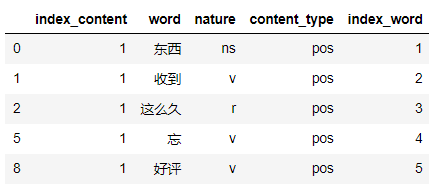

In [14]:
#分词，由元组组成的list
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  # psg.cut 类似于 nltk 的 pos tag

seg_content.shape
type(seg_content)
len(seg_content)
print(seg_content[6])

(1974,)

pandas.core.series.Series

1974

[('价格合理', 'n'), ('，', 'x'), ('配置', 'v'), ('挺', 'd'), ('高', 'a'), ('，', 'x'), ('物美', 'nz'), ('价值', 'n')]


In [15]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

1974

0    32
1    11
2     6
3    39
4    44
5    18
Name: content, dtype: int64

In [16]:
#test
list(seg_content.index)[:10],"*"*10,list(n_word)[:10]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 '**********',
 [32, 11, 6, 39, 44, 18, 8, 18, 102, 60])

In [17]:
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))] #[x+1]*y,表示复制y份，由list组成的list,x+1 (索引变成从1开始)
index_content_long=sum(n_content,[]) #表示去掉[]，拉平,返回list
len(index_content_long)

63794

In [18]:
#test
for i,n in enumerate(n_content[:6]):
    print(n[:2],len(n))

[1, 1] 32
[2, 2] 11
[3, 3] 6
[4, 4] 39
[5, 5] 44
[6, 6] 18


In [19]:
#test
sum([[2,2],[3,3,3]],[])

[2, 2, 3, 3, 3]

In [20]:
#分词及词性，去掉[]，拉平
seg_content.head()

seg_content_long=sum(seg_content,[])

seg_content_long

type(seg_content_long)
len(seg_content_long)

0    [(东西, ns), (收到, v), (这么久, r), (，, x), (都, d), ...
1    [(安装, v), (师傅, nr), (很, d), (给, p), (力, n), (，...
2    [(还, d), (没, v), (安装, v), (，, x), (基本, n), (满意...
3    [(收到, v), (了, ul), (，, x), (自营, vn), (商品, n), ...
4    [(用, p), (了, ul), (几次, m), (才, d), (来, v), (评价...
Name: content, dtype: object

[('东西', 'ns'),
 ('收到', 'v'),
 ('这么久', 'r'),
 ('，', 'x'),
 ('都', 'd'),
 ('忘', 'v'),
 ('了', 'ul'),
 ('去', 'v'),
 ('好评', 'v'),
 ('，', 'x'),
 ('大', 'a'),
 ('品牌', 'n'),
 ('，', 'x'),
 ('值得', 'v'),
 ('信赖', 'n'),
 ('，', 'x'),
 ('东西', 'ns'),
 ('整体', 'n'),
 ('来看', 'u'),
 ('，', 'x'),
 ('个人感觉', 'n'),
 ('还', 'd'),
 ('不错', 'a'),
 ('，', 'x'),
 ('没有', 'v'),
 ('出现', 'v'),
 ('什么', 'r'),
 ('问题', 'n'),
 ('，', 'x'),
 ('值得', 'v'),
 ('拥有', 'v'),
 ('！', 'x'),
 ('安装', 'v'),
 ('师傅', 'nr'),
 ('很', 'd'),
 ('给', 'p'),
 ('力', 'n'),
 ('，', 'x'),
 ('也好', 'y'),
 ('用', 'p'),
 ('，', 'x'),
 ('感谢', 'v'),
 ('。', 'x'),
 ('还', 'd'),
 ('没', 'v'),
 ('安装', 'v'),
 ('，', 'x'),
 ('基本', 'n'),
 ('满意', 'v'),
 ('收到', 'v'),
 ('了', 'ul'),
 ('，', 'x'),
 ('自营', 'vn'),
 ('商品', 'n'),
 ('就是', 'd'),
 ('好', 'a'),
 ('，', 'x'),
 ('发货', 'n'),
 ('速度', 'n'),
 ('快', 'a'),
 ('，', 'x'),
 ('品质', 'n'),
 ('有', 'v'),
 ('保障', 'v'),
 ('，', 'x'),
 ('安装', 'v'),
 ('效果', 'n'),
 ('好', 'a'),
 ('，', 'x'),
 ('宝贝', 'nr'),
 ('非常', 'd'),
 ('喜欢', 'v'),
 ('，', 'x'),
 ('

list

63794

In [21]:
seg_content_long[0]

('东西', 'ns')

In [22]:
#得到加长版的分词、词性
word_long=[x[0] for x in seg_content_long]
nature_long=[x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

63794

63794

In [23]:
#content_type拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['content_type']),list(n_word))] #[x+1]*y,表示复制y份
content_type_long=sum(n_content_type,[]) #表示去掉[]，拉平

len(content_type_long)

63794

In [24]:
content_type_long[24930:24940]#分界线

['neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg']

In [25]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})
review_long.shape
review_long.head()
review_long.tail()

(63794, 4)

,index_content,word,nature,content_type
0,1,东西,ns,pos
1,1,收到,v,pos
2,1,这么久,r,pos
3,1,，,x,pos
4,1,都,d,pos


,index_content,word,nature,content_type
63789,2000,一个,m,neg
63790,2000,至今,d,neg
63791,2000,未,d,neg
63792,2000,送到,v,neg
63793,2000,。,x,neg


（2）去除标点符号、去除停用词

In [26]:
review_long['nature'].unique()

array(['ns', 'v', 'r', 'x', 'd', 'ul', 'a', 'n', 'u', 'nr', 'p', 'y',
       'vn', 't', 'c', 'm', 'l', 'b', 'i', 'uj', 'zg', 's', 'uz', 'nz',
       'f', 'uv', 'ad', 'q', 'j', 'g', 'ud', 'an', 'nrt', 'vg', 'ng', 'k',
       'o', 'mq', 'df', 'e', 'vd', 'z', 'nt', 'tg', 'rz', 'ug', 'yg', 'h',
       'vq', 'ag', 'rr'], dtype=object)

In [27]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x'] #x表示标点符合
review_long_clean.shape

(51436, 4)

In [28]:
#导入停用词
stop_path=open('./stoplist.txt','r',encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[:15]

5748

['\ufeff \n',
 '说\n',
 '人\n',
 '元\n',
 'hellip\n',
 '&\n',
 ',\n',
 '?\n',
 '、\n',
 '。\n',
 '"\n',
 '"\n',
 '《\n',
 '》\n',
 '！\n']

In [29]:
#停用词，预处理
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:15]

['\ufeff ',
 '说',
 '人',
 '元',
 'hellip',
 '&',
 ',',
 '?',
 '、',
 '。',
 '"',
 '"',
 '《',
 '》',
 '！']

In [30]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
#isin()的反函数df[～df].isin()
review_long_clean.shape

4455

(25172, 4)

(3)在原df中，再增加一列:该分词在本条评论的位置(index)

In [31]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[]) #表示去掉[]，拉平

len(index_word_long)

index_content
1       14
2        4
3        2
4       20
5       23
        ..
1996     6
1997    20
1998     3
1999    10
2000     4
Name: word, Length: 1964, dtype: int64

25172

In [32]:
#test
list(np.arange(1,3))

[1, 2]

In [33]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,1
1,1,收到,v,pos,2
2,1,这么久,r,pos,3
5,1,忘,v,pos,4
8,1,好评,v,pos,5


In [34]:
review_long_clean.to_csv('1_review_long_clean.csv',index=False,encoding='utf-8-sig')

(4)提取名词

In [35]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(10189, 5)

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,1
11,1,品牌,n,pos,6
14,1,信赖,n,pos,8
16,1,东西,ns,pos,9
17,1,整体,n,pos,10


In [36]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('./1_n_review_long_clean.csv',index=False,encoding='utf-8-sig')

n      8086
nr      724
vn      699
ns      416
nz      136
ng       60
nrt      36
an       25
nt        7
Name: nature, dtype: int64

（5）词云图

<Figure size 2000x1000 with 0 Axes>

(-0.5, 473.5, 473.5, -0.5)

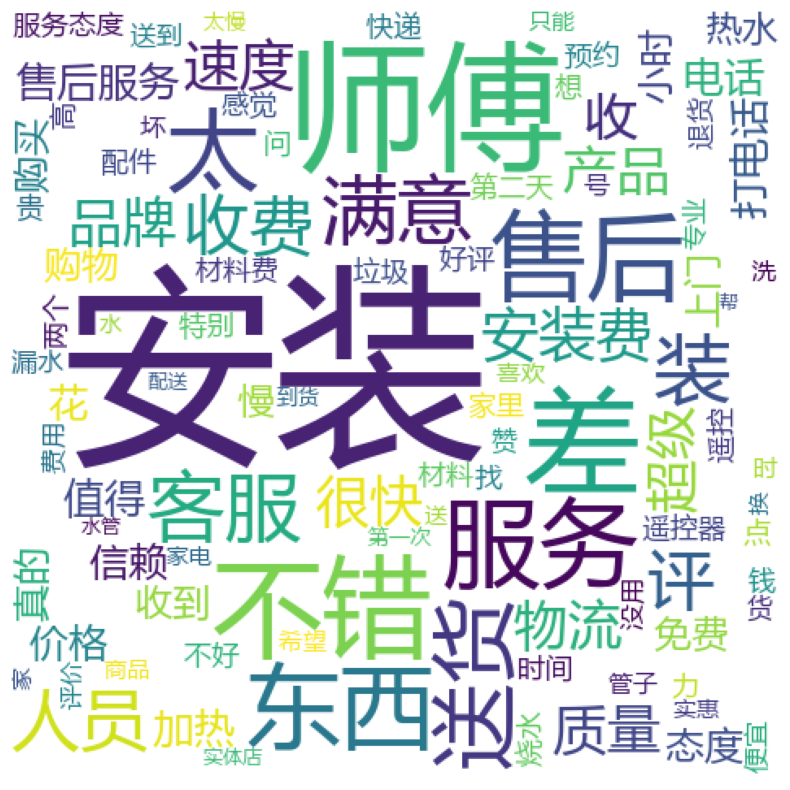

In [37]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./p1.jpg')
#font_path：指定文体文件的路径，默认None;  
#mask：指定词云形状，默认为长方形，需要引用imread()函数
#background_color：指定词云图片的背景颜色，默认为黑色
wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white',mask=background_image) #width=1600,height=1200, mode='RGBA'
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 2000x1000 with 0 Axes>

(-0.5, 1023.5, 1023.5, -0.5)

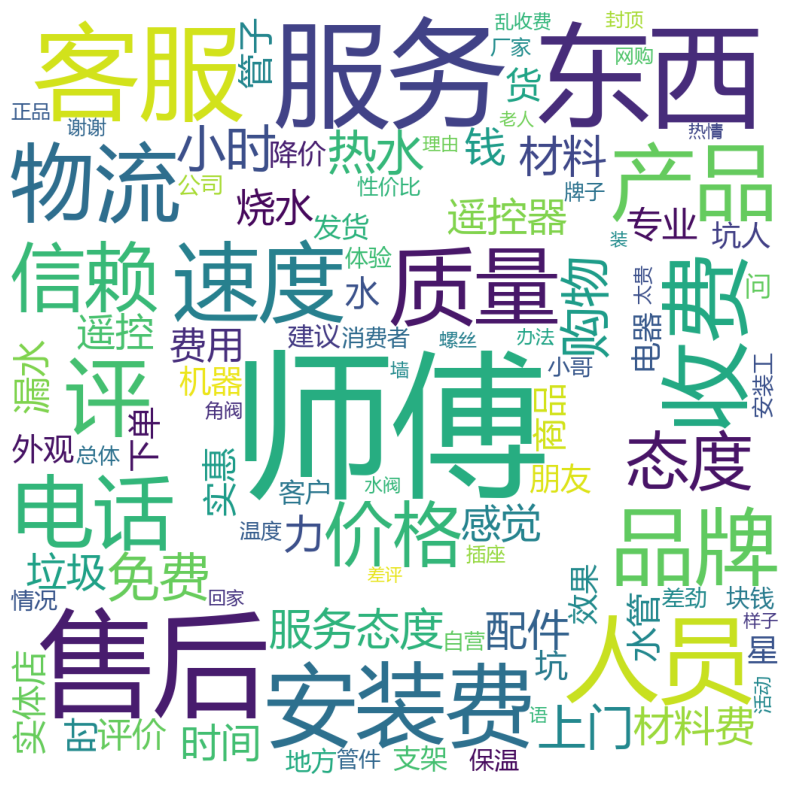

In [38]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./p2.jpg')# 图片自己提前准备好，形状自己设置，后面会映射到词云的形状 
#font_path：指定文体文件的路径，默认None;  
#mask：指定词云形状，默认为长方形，需要引用imread()函数
#background_color：指定词云图片的背景颜色，默认为黑色 
#width=1600,height=1200
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image)
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 三、模型构建

### （一）基于决策树的情感分类

In [39]:
review_long_clean

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,1
1,1,收到,v,pos,2
2,1,这么久,r,pos,3
5,1,忘,v,pos,4
8,1,好评,v,pos,5
...,...,...,...,...,...
63780,1999,差,a,neg,10
63783,2000,两个,m,neg,1
63785,2000,送到,v,neg,2
63791,2000,未,d,neg,3


In [41]:
review_long_clean.index_content.unique()

array([   1,    2,    3, ..., 1998, 1999, 2000], dtype=int64)

In [43]:
review_long_clean.content_type[review_long_clean.index_content==1].unique()

array(['pos'], dtype=object)

In [45]:
review_long_clean.word[review_long_clean.index_content==1].values

array(['东西', '收到', '这么久', '忘', '好评', '品牌', '值得', '信赖', '东西', '整体', '个人感觉',
       '不错', '值得', '拥有'], dtype=object)

In [40]:
#第一步：构造特征空间和标签

Y=[]
for ind in review_long_clean.index_content.unique():
    y=[ word for word in review_long_clean.content_type[review_long_clean.index_content==ind].unique() ]
    Y.append(y)
len(Y)

X=[]
for ind in review_long_clean.index_content.unique():
    term=[ word for word in review_long_clean.word[review_long_clean.index_content==ind].values ]
    X.append(' '.join(term))
len(X)

X[:2]
Y[:2]

1964

1964

['东西 收到 这么久 忘 好评 品牌 值得 信赖 东西 整体 个人感觉 不错 值得 拥有', '安装 师傅 力 感谢']

[['pos'], ['pos']]

In [51]:
#第二步：训练集、测试集划分
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7)

#第三步：词转向量，01矩阵
count_vec=CountVectorizer(binary=True) 
#为了数据归一化（使特征数据方差为1，均值为0），需要计算特征数据的均值μ和方差σ^2
x_train=count_vec.fit_transform(x_train)#训练集训练之后词转向量

x_test=count_vec.transform(x_test)  # 测试集是训练集训练之后对测试集词转向量

#第四步：构建决策树
dtc=tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(x_train,y_train)
print('在训练集上的准确率：%.2f'% accuracy_score(y_train,dtc.predict(x_train)))

y_true=y_test
y_pred=dtc.predict(x_test)
print(classification_report(y_true,y_pred,output_dict=False))
print('在测试集上的准确率：%.2f'% accuracy_score(y_true,y_pred))

DecisionTreeClassifier(max_depth=5)

在训练集上的准确率：0.72
              precision    recall  f1-score   support

         neg       0.63      0.96      0.76       197
         pos       0.92      0.44      0.60       196

    accuracy                           0.70       393
   macro avg       0.78      0.70      0.68       393
weighted avg       0.77      0.70      0.68       393

在测试集上的准确率：0.70


In [53]:
print(classification_report(y_true,y_pred,output_dict=True))

{'neg': {'precision': 0.6342281879194631, 'recall': 0.9593908629441624, 'f1-score': 0.7636363636363636, 'support': 197}, 'pos': {'precision': 0.9157894736842105, 'recall': 0.44387755102040816, 'f1-score': 0.5979381443298968, 'support': 196}, 'accuracy': 0.7022900763358778, 'macro avg': {'precision': 0.7750088308018368, 'recall': 0.7016342069822853, 'f1-score': 0.6807872539831301, 'support': 393}, 'weighted avg': {'precision': 0.7746506103364873, 'recall': 0.7022900763358778, 'f1-score': 0.6809980659669806, 'support': 393}}


In [57]:
#打印下混淆矩阵
print(confusion_matrix(y_true,y_pred))
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

[[189   8]
 [109  87]]


In [58]:
#precison表示精度=TP/(TP+FP)
#recall表示召回率或者敏感度，sensitivity=TP/(TP+FN)
# F1 = 2 * (precision * recall) / (precision + recall)
P = 189/(189+8)
R = 189/(189+109)
F1 = 2*(P*R)/(P+R)
P ,R , F1

(0.9593908629441624, 0.6342281879194631, 0.7636363636363636)

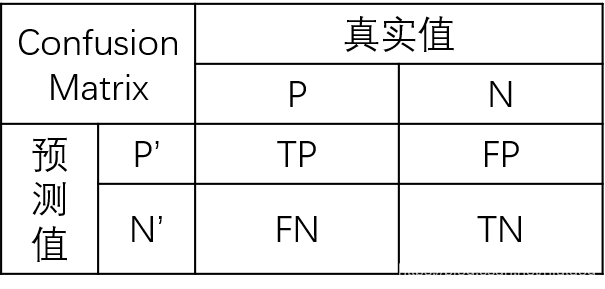

In [61]:
dir(count_vec)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_feature_names',
 '_check_n_features',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sort_features',
 '_stop_words_id',
 '_validate_data',
 '_validate_params',
 '_validate_vocabulary',
 '_warn_for_unused_params',
 '_white_spaces',
 '_word_ngrams',
 'analyzer',
 'binary',
 'build_analyzer',
 'build_preprocessor',
 'build_tokenizer',
 'decode',
 'decode_error',
 'dtype',
 'encoding',
 'fit',

In [70]:
count_vec.get_feature_names()[790],count_vec.get_feature_names()[781]

('升与', '十天')

In [66]:
count_vec.get_feature_names()

['一万',
 '一万个',
 '一上午',
 '一下子',
 '一两块',
 '一两天',
 '一个劲',
 '一个多',
 '一个多月',
 '一个月',
 '一个桶',
 '一个角',
 '一会',
 '一会儿',
 '一体化',
 '一倍',
 '一共',
 '一再',
 '一再强调',
 '一分',
 '一分货',
 '一分钟',
 '一分钱',
 '一刻',
 '一副',
 '一十五',
 '一千',
 '一千元',
 '一千只',
 '一千块',
 '一千多',
 '一半',
 '一口气',
 '一句',
 '一只',
 '一台',
 '一号',
 '一周',
 '一响',
 '一回',
 '一圈',
 '一块',
 '一块儿',
 '一堆',
 '一塌糊涂',
 '一声',
 '一夜',
 '一大',
 '一大堆',
 '一大早',
 '一大笔钱',
 '一套',
 '一如',
 '一如既往',
 '一学',
 '一定量',
 '一家',
 '一家人',
 '一小',
 '一层',
 '一年',
 '一度',
 '一建',
 '一开',
 '一张',
 '一拖再拖',
 '一招',
 '一日',
 '一早',
 '一本',
 '一条',
 '一条线',
 '一条龙',
 '一根',
 '一档',
 '一模一样',
 '一次性',
 '一次次',
 '一款',
 '一步',
 '一段时间',
 '一流',
 '一点',
 '一点半',
 '一点点',
 '一百',
 '一百三十',
 '一百个',
 '一百二',
 '一百元',
 '一百四五十',
 '一百块',
 '一百多',
 '一百多块',
 '一盒',
 '一目了然',
 '一看',
 '一种',
 '一笔',
 '一篇',
 '一米',
 '一系列',
 '一级',
 '一线',
 '一群',
 '一肚子',
 '一肚子气',
 '一肚子火',
 '一股',
 '一脸',
 '一般般',
 '一节',
 '一莫',
 '一路',
 '一车',
 '一通',
 '一遍',
 '一部分',
 '一键',
 '一项',
 '一顿',
 '一颗',
 '七八',
 '七八天',
 '七八百',
 '七十',
 '七十五',
 '七十多岁',
 '七天',
 '七百元',
 '万家乐',
 '丈人',

'C:\\Users\\Administrator\\temp_script\\电商产品评论数据情感分析\\tree.svg'

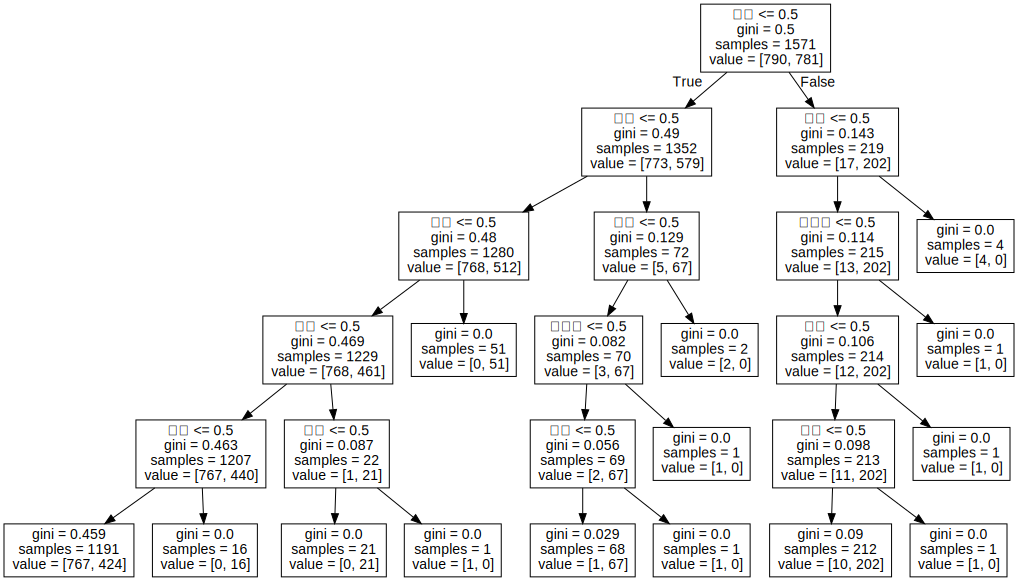

In [71]:
#第五步：画决策树，查看重要词汇
## gini 基尼系数
## sample=1571 划分前的样本数为1571
## value =[790，781] 样本标签有两类，数量分别为790和781
cwd=os.getcwd()
dot_data=tree.export_graphviz(dtc
                              ,out_file=None
                              ,feature_names=count_vec.get_feature_names()#每个特征的名字
                             )#生成决策树的可视化表示
graph=graphviz.Source(dot_data)
graph.format='svg'
graph.render(cwd+'/tree',view=True)
graph


### （二）情感分析

数据预处理的思路与目标

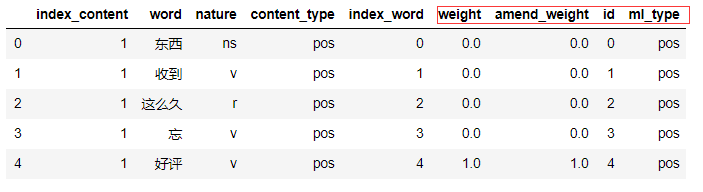

(1)导入评价情感词

In [77]:
#来自知网发布的情感分析用词语集
#如果是情感词weight未1，负责为0，amend—weight表示修正次，比如‘不是’，‘不好’中的‘不’，如果是修正词就为1，否则为0
#
pos_comment=pd.read_csv('./正面评价词语（中文）.txt',header=None,sep='/n',encoding='utf-8') 
neg_comment=pd.read_csv('./负面评价词语（中文）.txt',header=None,sep='/n',encoding='utf-8')
 
# with open('./正面情感词语（中文）.txt',encoding='utf-8') as f:
#     pos_emotion=[i.strip() for i in f.readlines()]
# with open('./负面情感词语（中文）.txt',encoding='utf-8') as f:
#     pos_emotion=[i.strip() for i in f.readlines()]
pos_emotion=pd.read_csv('./正面情感词语（中文）.txt',header=None,sep='/n',encoding='utf-8')
neg_emotion=pd.read_csv('./负面情感词语（中文）.txt',header=None,sep='/n',encoding='utf-8')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\2906339440.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pos_comment=pd.read_csv('./正面评价词语（中文）.txt',header=None,sep='/n',encoding='utf-8')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\2906339440.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  neg_comment=pd.read_csv('./负面评价词语（中文）.txt',header=None,sep='/n',encoding='utf-8')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\2906339440.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char an

In [78]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [79]:
pos=pd.concat([pos_comment,pos_emotion],axis=0)
pos.shape

neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape

(4576, 1)

(4389, 1)

(2)增加新词（例子）

In [82]:
c='点赞'
c in pos.values

d='歇菜'
d in neg.values
# 两个词都不在数据集里

False

False

In [84]:
#拼接（追加上）
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['歇菜'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [85]:
# 设置字段名，添加权重列
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [86]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [87]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape

(8967, 2)

In [88]:
pos_neg

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1
...,...,...
1247,黯然神伤,-1
1248,黯然销魂,-1
1249,威胁,-1
1250,欺骗,-1


(3)合并到review_long_clean中

In [94]:
review_long_clean

,index_content,word,nature,content_type,index_word
0,1,东西,ns,pos,1
1,1,收到,v,pos,2
2,1,这么久,r,pos,3
5,1,忘,v,pos,4
8,1,好评,v,pos,5
...,...,...,...,...,...
63780,1999,差,a,neg,10
63783,2000,两个,m,neg,1
63785,2000,送到,v,neg,2
63791,2000,未,d,neg,3


In [95]:
#表联接

data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')#左连接
review_mltype.shape



(25793, 7)

In [96]:
review_mltype

,index_content,word,nature,content_type,index_word,review,weight
0,1,东西,ns,pos,1,NaN,NaN
1,1,收到,v,pos,2,NaN,NaN
2,1,这么久,r,pos,3,NaN,NaN
3,1,忘,v,pos,4,NaN,NaN
4,1,好评,v,pos,5,好评,1.0
...,...,...,...,...,...,...,...
25788,1999,差,a,neg,10,差,-1.0
25789,2000,两个,m,neg,1,NaN,NaN
25790,2000,送到,v,neg,2,NaN,NaN
25791,2000,未,d,neg,3,NaN,NaN


In [97]:
review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype

,index_content,word,nature,content_type,index_word,weight
0,1,东西,ns,pos,1,0.0
1,1,收到,v,pos,2,0.0
2,1,这么久,r,pos,3,0.0
3,1,忘,v,pos,4,0.0
4,1,好评,v,pos,5,1.0
...,...,...,...,...,...,...
25788,1999,差,a,neg,10,-1.0
25789,2000,两个,m,neg,1,0.0
25790,2000,送到,v,neg,2,0.0
25791,2000,未,d,neg,3,0.0


(4)修正情感倾向，

如有多重否定，那么奇数否定是否定，偶数否定是肯定

看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

In [98]:
notdict=pd.read_csv('./not.csv')
notdict.shape

notdict['freq']=[1]*len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [102]:
#准备一
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,东西,ns,pos,1,0.0,0.0,0
1,1,收到,v,pos,2,0.0,0.0,1
2,1,这么久,r,pos,3,0.0,0.0,2
3,1,忘,v,pos,4,0.0,0.0,3
4,1,好评,v,pos,5,1.0,1.0,4
...,...,...,...,...,...,...,...,...
25788,1999,差,a,neg,10,-1.0,-1.0,25788
25789,2000,两个,m,neg,1,0.0,0.0,25789
25790,2000,送到,v,neg,2,0.0,0.0,25790
25791,2000,未,d,neg,3,0.0,0.0,25791


In [104]:
# 准备二，只保留有情感值的行

only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
4,1,好评,v,pos,5,1.0,1.0,4
6,1,值得,v,pos,7,1.0,1.0,6
7,1,信赖,n,pos,8,1.0,1.0,7
11,1,不错,a,pos,12,1.0,1.0,11
12,1,值得,v,pos,13,1.0,1.0,12
...,...,...,...,...,...,...,...,...
25775,1997,郁闷,a,neg,20,-1.0,-1.0,25775
25776,1998,好不容易,l,neg,1,-1.0,-1.0,25776
25778,1998,漏电,nz,neg,3,-1.0,-1.0,25778
25781,1999,挺快,v,neg,3,1.0,1.0,25781


In [105]:
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype

(5115, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,好评,v,pos,5,1.0,1.0,4
1,1,值得,v,pos,7,1.0,1.0,6
2,1,信赖,n,pos,8,1.0,1.0,7
3,1,不错,a,pos,12,1.0,1.0,11
4,1,值得,v,pos,13,1.0,1.0,12
...,...,...,...,...,...,...,...,...
5110,1997,郁闷,a,neg,20,-1.0,-1.0,25775
5111,1998,好不容易,l,neg,1,-1.0,-1.0,25776
5112,1998,漏电,nz,neg,3,-1.0,-1.0,25778
5113,1999,挺快,v,neg,3,1.0,1.0,25781


In [112]:
i=20
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
75,7,价格合理,n,pos,1,0.0,0.0,75
76,7,配置,v,pos,2,0.0,0.0,76
77,7,高,a,pos,3,1.0,1.0,77
78,7,高,a,pos,3,-1.0,-1.0,78
79,7,物美,nz,pos,4,1.0,1.0,79
80,7,价值,n,pos,5,0.0,0.0,80


In [115]:
i=30
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
128,10,安装,v,pos,1,0.0,0.0,128
129,10,小哥,n,pos,2,0.0,0.0,129
130,10,工作,vn,pos,3,0.0,0.0,130
131,10,尽心,d,pos,4,1.0,1.0,131
132,10,家,m,pos,5,0.0,0.0,132
133,10,老房子,n,pos,6,0.0,0.0,133
134,10,安装,v,pos,7,0.0,0.0,134
135,10,家,m,pos,8,0.0,0.0,135
136,10,费力,n,pos,9,-1.0,-1.0,136
137,10,安装,v,pos,10,0.0,0.0,137


In [116]:
only_review_mltype.shape

(5115, 8)

In [117]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index=np.arange(0,review_i.shape[0])#重置索引后，索引值等价于index_word
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne==1:
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [118]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] #说明两列值一样

(25793, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


(5)计算每条评论的情感值

In [120]:
review_mltype

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,东西,ns,pos,1,0.0,0.0,0
1,1,收到,v,pos,2,0.0,0.0,1
2,1,这么久,r,pos,3,0.0,0.0,2
3,1,忘,v,pos,4,0.0,0.0,3
4,1,好评,v,pos,5,1.0,1.0,4
...,...,...,...,...,...,...,...,...
25788,1999,差,a,neg,10,-1.0,-1.0,25788
25789,2000,两个,m,neg,1,0.0,0.0,25789
25790,2000,送到,v,neg,2,0.0,0.0,25790
25791,2000,未,d,neg,3,0.0,0.0,25791


In [121]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('./1_emotion_value',index=True,header=True)

,index_content,amend_weight
0,1,5.0
1,2,2.0
2,3,2.0
3,4,5.0
4,5,4.0


(6)查看情感分析效果

In [122]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value

(1964, 2)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\3787808543.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2524\3787808543.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'


(1491, 3)

,index_content,amend_weight,ml_type
0,1,5.0,pos
1,2,2.0,pos
2,3,2.0,pos
3,4,5.0,pos
4,5,4.0,pos
...,...,...,...
1956,1993,-2.0,neg
1957,1994,-1.0,neg
1958,1995,-1.0,neg
1959,1996,-3.0,neg


In [123]:
#每条评论的amend_weight总和等于零
#这个方法其实不好用，有一半以上的评论区分不出正、负情感。

content_emotion_value0=emotion_value.copy()
content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
content_emotion_value0.head()

raw_data.content[6]
raw_data.content[7]
raw_data.content[8]

,index_content,amend_weight
19,20,0.0
20,21,0.0
25,26,0.0
33,34,0.0
46,47,0.0


'价格合理，配置挺高，物美价值'

'老师按装是快的，装修中。没试。希望是正常的！'

'五分是习惯\r\n送的快，装的也快，很好，不过装修进行中，为了吊顶只装了热水器，其它后话吧。\r\n我也是醉了，热水器遥控器没电池，还是安装哥车里有一个备用的给装上了。\r\n要赠送的电动牙刷，空气净化器等待配送中&hellip;&hellip;。\r\n一天时间冰箱降100、洗衣机降40、热水器降100、小厨宝降30、烟灶套降100。不过客服说上报解决，电话通知等待中&hellip;&hellip;'

In [124]:
#合并到大表中

content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype

review_mltype.to_csv('./1_review_mltype',index=True,header=True)

(25793, 8)

(25793, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,东西,ns,pos,1,0.0,0.0,pos
1,1,收到,v,pos,2,0.0,0.0,pos
2,1,这么久,r,pos,3,0.0,0.0,pos
3,1,忘,v,pos,4,0.0,0.0,pos
4,1,好评,v,pos,5,1.0,1.0,pos
...,...,...,...,...,...,...,...,...
25788,1999,差,a,neg,10,-1.0,-1.0,NaN
25789,2000,两个,m,neg,1,0.0,0.0,NaN
25790,2000,送到,v,neg,2,0.0,0.0,NaN
25791,2000,未,d,neg,3,0.0,0.0,NaN


In [125]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True)
confusion_matrix

ml_type,neg,pos,All
content_type,,,
neg,515,193,708
pos,39,744,783
All,554,937,1491


In [126]:
data=data_type[['content_type','ml_type']]
data=data.dropna(axis=0)
print( classification_report(data['content_type'],data['ml_type']) )

              precision    recall  f1-score   support

         neg       0.93      0.73      0.82       708
         pos       0.79      0.95      0.87       783

    accuracy                           0.84      1491
   macro avg       0.86      0.84      0.84      1491
weighted avg       0.86      0.84      0.84      1491



In [127]:
data

,content_type,ml_type
0,pos,pos
14,pos,pos
19,pos,pos
22,pos,pos
43,pos,pos
...,...,...
25717,neg,neg
25739,neg,neg
25745,neg,neg
25750,neg,neg


(7)制作词云图

- 只看情感词

In [128]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

<Figure size 1500x700 with 0 Axes>

(-0.5, 519.5, 519.5, -0.5)

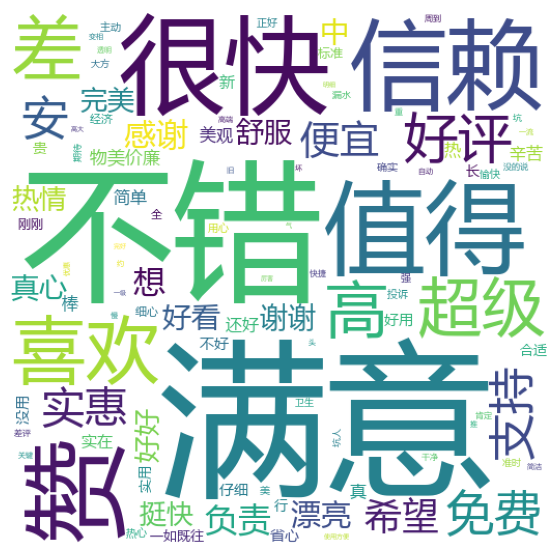

In [130]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./p5smile.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1080x504 with 0 Axes>

(-0.5, 525.5, 253.5, -0.5)

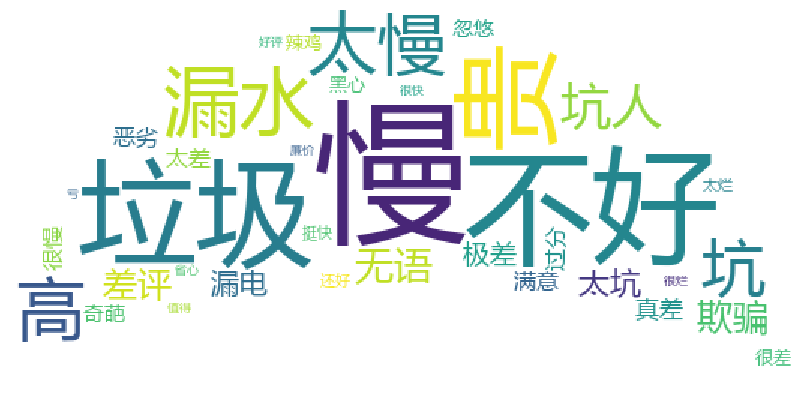

In [67]:
font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./p6sad.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 看所有词

<Figure size 1500x700 with 0 Axes>

(-0.5, 519.5, 519.5, -0.5)

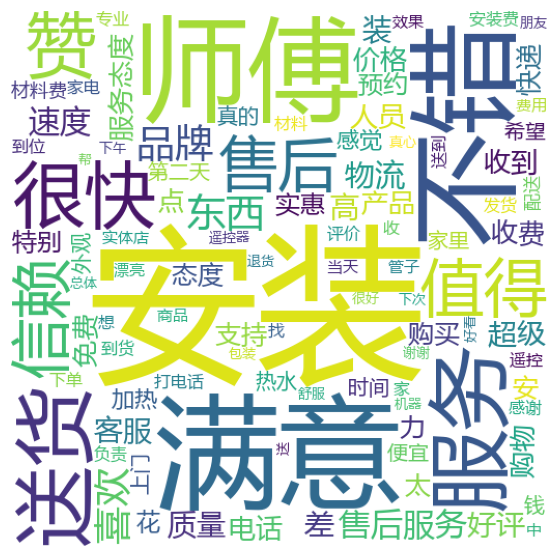

<Figure size 1500x700 with 0 Axes>

(-0.5, 519.5, 519.5, -0.5)

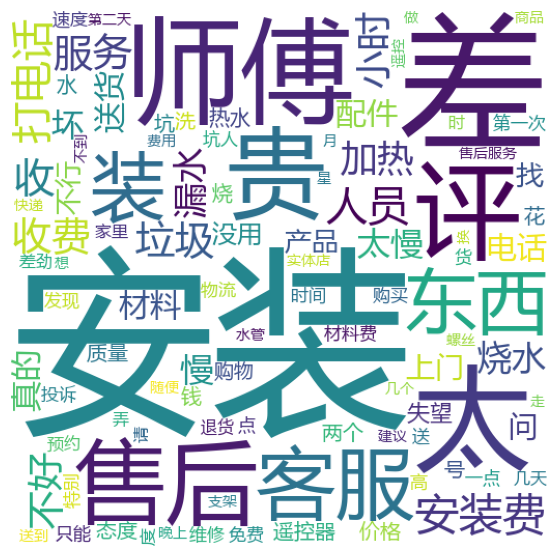

In [132]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font=r"C:\Windows\Fonts\msyh.ttc"

background_image=plt.imread('./p5smile.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

background_image=plt.imread('./p5smile.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### （三）基于LDA模型的主题分析

优点：不需要人工调试，用相对少的迭代找到最优的主题结构。

（1）建立词典、语料库

In [133]:
from gensim import corpora,models #主题挖掘，提取关键信息

data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

In [134]:
word_data_pos

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,东西,ns,pos,1,0.0,0.0,pos
1,1,收到,v,pos,2,0.0,0.0,pos
2,1,这么久,r,pos,3,0.0,0.0,pos
3,1,忘,v,pos,4,0.0,0.0,pos
4,1,好评,v,pos,5,1.0,1.0,pos
...,...,...,...,...,...,...,...,...
25684,1990,免费,vn,neg,1,1.0,1.0,pos
25685,1990,安装,v,neg,2,0.0,0.0,pos
25686,1990,花,v,neg,3,0.0,0.0,pos
25687,1990,费用,n,neg,4,0.0,0.0,pos


In [135]:
word_data_neg

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
154,11,前,f,pos,1,0.0,0.0,neg
155,11,天下,s,pos,2,0.0,0.0,neg
156,11,单买,v,pos,3,0.0,0.0,neg
157,11,用上,v,pos,4,0.0,0.0,neg
158,11,发现,v,pos,5,0.0,0.0,neg
...,...,...,...,...,...,...,...,...
25754,1996,千万别,i,neg,5,0.0,0.0,neg
25755,1996,上当,v,neg,6,0.0,0.0,neg
25776,1998,好不容易,l,neg,1,-1.0,-1.0,neg
25777,1998,网购,n,neg,2,0.0,0.0,neg


In [136]:
#建立词典，去重

pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [140]:
print(pos_dict),print(neg_dict)

Dictionary<2648 unique tokens: ['东西', '收到', '这么久', '忘', '好评']...>
Dictionary<2306 unique tokens: ['前', '天下', '单买', '用上', '发现']...>


(None, None)

In [141]:
#建立语料库

pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] #shape=(n,(2,1))
neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

In [142]:
len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus  #元素是元组，元组（x,y),x是在词典中的位置，y是1表示存在。

12499

2648

12499

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(7, 1)],
 [(0, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(6, 1)],
 [(11, 1)],
 [(12, 1)],
 [(13, 1)],
 [(14, 1)],
 [(15, 1)],
 [(15, 1)],
 [(12, 1)],
 [(16, 1)],
 [(16, 1)],
 [(1, 1)],
 [(17, 1)],
 [(18, 1)],
 [(19, 1)],
 [(20, 1)],
 [(21, 1)],
 [(22, 1)],
 [(12, 1)],
 [(23, 1)],
 [(24, 1)],
 [(25, 1)],
 [(25, 1)],
 [(26, 1)],
 [(27, 1)],
 [(28, 1)],
 [(17, 1)],
 [(6, 1)],
 [(7, 1)],
 [(6, 1)],
 [(29, 1)],
 [(17, 1)],
 [(30, 1)],
 [(31, 1)],
 [(32, 1)],
 [(16, 1)],
 [(16, 1)],
 [(33, 1)],
 [(34, 1)],
 [(35, 1)],
 [(36, 1)],
 [(37, 1)],
 [(38, 1)],
 [(39, 1)],
 [(40, 1)],
 [(41, 1)],
 [(42, 1)],
 [(43, 1)],
 [(44, 1)],
 [(12, 1)],
 [(45, 1)],
 [(46, 1)],
 [(47, 1)],
 [(48, 1)],
 [(49, 1)],
 [(50, 1)],
 [(51, 1)],
 [(38, 1)],
 [(52, 1)],
 [(33, 1)],
 [(20, 1)],
 [(53, 1)],
 [(10, 1)],
 [(38, 1)],
 [(54, 1)],
 [(55, 1)],
 [(56, 1)],
 [(56, 1)],
 [(57, 1)],
 [(58, 1)],
 [(59, 1)],
 [(60, 1)],
 [(61, 1)],
 [(62, 1

(2)主题数寻优


In [143]:
#构造主题数寻优函数

def cos(vector1,vector2):
    '''
    函数功能：余玄相似度函数
    值越小越相似
    '''
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [144]:
#主题数寻优
#这个函数可以重复调用，解决其他项目的问题

def LDA_k(x_corpus,x_dict):
    '''
    函数功能：
    '''
    #初始化平均余玄相似度
    mean_similarity=[]
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda=models.LdaModel(x_corpus,num_topics=i,id2word=x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term=lda.show_topics(num_words=50)
        
        #提取各主题词
        top_word=[] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word=sum(top_word,[]) #列车所有词
        unique_word=set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat=[] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w=top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
        y=len(p) # y=i*(i-1)
        top_similarity=[0]
        for w in np.arange(y):
            vector1=mat[p[w][0]]
            vector2=mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))

#        #两两组合，方法二
#        for x in range(i-1):
#            for y in range(x,i):
            
        #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

In [145]:
#计算主题平均余玄相似度

pos_k=LDA_k(pos_corpus,pos_dict)
neg_k=LDA_k(neg_corpus,neg_dict)

pos_k
neg_k

[1,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0007142857142857143,
 0.0027777777777777775,
 0.011111111111111117]

[1,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0038095238095238095,
 0.007857142857142858,
 0.010000000000000004,
 0.01422222222222223]

<AxesSubplot:>

Text(0.5, 1.0, '正面评论LDA主题数寻优')

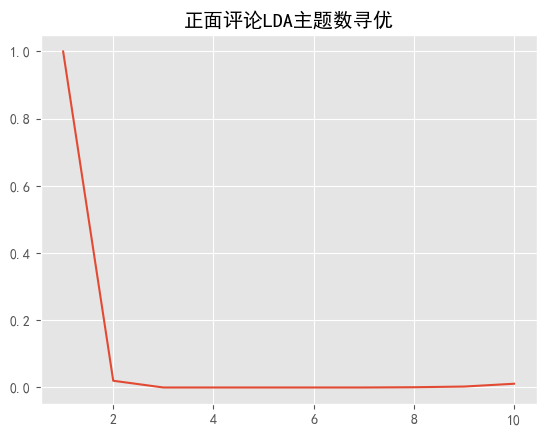

In [146]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, '负面评论LDA主题数寻优')

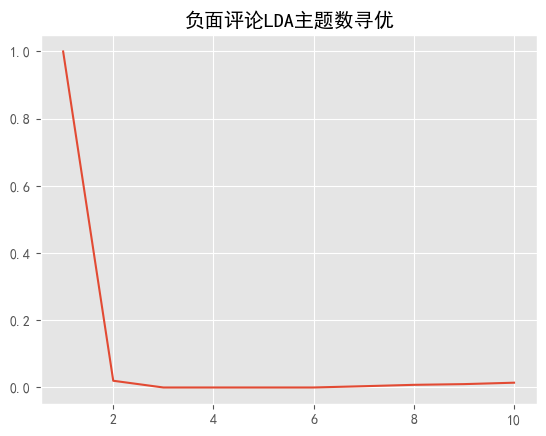

In [147]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [148]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)

pos_lda.print_topics(num_topics=10)
neg_lda.print_topics(num_topics=10)

[(0,
  '0.109*"安装" + 0.035*"满意" + 0.025*"师傅" + 0.017*"不错" + 0.017*"免费" + 0.017*"售后服务" + 0.015*"服务" + 0.014*"装" + 0.014*"人员" + 0.010*"钱"'),
 (1,
  '0.019*"差" + 0.018*"超级" + 0.014*"售后" + 0.014*"客服" + 0.013*"电话" + 0.012*"安装费" + 0.012*"安" + 0.012*"送货" + 0.011*"东西" + 0.009*"收费"')]

[(0,
  '0.028*"太" + 0.025*"贵" + 0.022*"评" + 0.016*"客服" + 0.016*"安装费" + 0.012*"打电话" + 0.012*"不好" + 0.010*"坏" + 0.010*"太慢" + 0.009*"收费"'),
 (1,
  '0.076*"安装" + 0.041*"差" + 0.021*"垃圾" + 0.020*"师傅" + 0.016*"东西" + 0.015*"装" + 0.013*"售后" + 0.013*"收" + 0.011*"服务" + 0.011*"加热"')]

### 总结

>本案例首先利用Python文本挖掘技术，对碎片化、非结构化的电商网站评论数据进行清洗与处理，转化为结构化数据。然后对文本数据进一步挖掘与分析，采用决策树算法构建情感分类模型，探索用机器学习算法对评论标注type的可能性；依据情感词库匹配情感词，计算每条评论的情感值，进而机器标注每条评论的正负类型type，用词云图直观呈现正负评论的关键词，初步获得用户的反馈意见。最后利用gensim库构建主题挖掘模型，深入了解用户的意见、购买原因、产品的优缺点等。

In [149]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
